<img src = "https://imgur.com/HE0kDhA.jpg"  align = "center">

# **Transfer Learning**

Pada praktikum Modul 6 anda **disarankan menggunakan Google Colab** dengan jenis runtime **GPU**

Anda diharus menggunakan dataset Colorectal Histology yang dapat diunduh melalui: https://www.tensorflow.org/datasets/catalog/colorectal_histology
dataset tersebut merupakan gambar segmentasi mikroskopis kanker usus besar (Colorectal Histology) dengan ukuran 150x150, 3 channel RGB berjumlah 5000 gambar

Pada dataset tersebut terdapat 8 jenis lapisan (tissue) class atau labels yaitu: 
- 0, tumor
- 1, stroma
- 2, complex
- 3, lympho
- 4, debris
- 5, mucosa
- 6, adipose
- 7, empty (background, no tissue)

Jika anda tertarik lebih lanjut mengenai dataset tersebut anda dapat melihat pada referensi paper berikut: https://www.nature.com/articles/srep27988

Tugas utama anda sesuai dengan yang ditunjukkan oleh Gambar 1. yaitu membuat model menggunakan metode Transfer Learning, anda dapat membuat model eksperiment pada bagian **eksperiment layer** dengan improvisasi dari penerapan modul sebelumnya. Anda diharuskan membuat **2 Model Percobaan** dengan kriteria:
- minimal **2 kombinasi pretrained architectures** yang berbeda sebagai ekstraksi fitur.
- training pembobotan dilakukan pada layer eksperiment dengan menerapkan improvisasi training pada modul sebelumnya
- referensi pretrained arsitektur yang terdapat pada keras dapat anda lihat di laman berikut: https://www.tensorflow.org/api_docs/python/tf/keras/applications

<img src = "https://i.imgur.com/4iskeo2.png" align="center">
<br/>
<h4>Gambar 1. Rancangan Model Kegiatan 6<h4/>

Untuk menguji hasil model experiment, anda diharuskan membagi dataset menjadi 20% sebagai data testing dan 80% sebagai data training sehingga jumlah hasil pembagian images menjadi:
- 1000 images testing
- 4000 images training

**Poin penilaian :**

* Tingkat kesesuaian code
* Tingkat kesesuaian output
* Kesesuaian step preprocessing dan pemodelan
* Kesesuaian jawaban dengan konten materi modul
* Penerapan improvisasi model sesuai dengan modul sebelumnya
* Pemahaman materi Tranfer Learning
* Kerapian kode program
* Total masing-masing point



---



---



# 1. Preprocessing (20 + 5 point)
task yang perlu dikerjakan:
- 1. load dataset, anda bisa menggunakan library tensorflow bernama tfds (disarankan) atau mengunduh secara manual (5 point)
- 2. membagi dataset dan menampilkan hasil pembagian (10 point)
- 3. menampilkan sample gambar colorectal histology (5 point)
- 4. normalisasi rescale gambar dan menerapkan image data generator jika diperlukan (tambahan 5 point jika menerapkan image data generator yang mencakup dari modul sebelumnya)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Hasil pengerjaan point 1.1
%cd /content/drive/MyDrive/Colab Notebooks/modul6

/content/drive/MyDrive/Colab Notebooks/modul6


In [3]:
pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 3.7MB 17.2MB/s 


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
# ds, ds_info = tfds.load('colorectal_histology', split='train', shuffle_files=True, with_info=True, data_dir='modul6/' )
# assert isinstance(ds, tf.data.Dataset)
# print(ds_info)


ds, ds_info = tfds.load(
    'colorectal_histology',
    split='train[:20%]+train[-80%:]',
    with_info=True,
    as_supervised=True,
    data_dir='dataset/'
    )

In [ ]:
# !mv -t dataset/ dataset/downloads/extracted/ZIP.zeno.org_reco_5316_file_Kath_text_2016_imak20Lla4PBPH3sYorfoxVd2w-iH0QL2RbzudS0aZiajI.zip/Kather_texture_2016_image_tiles_5000

In [ ]:
# Hasil pengerjaan point 1.2
!pip install split-folders

In [5]:
data_dir ='dataset/Kather_texture_2016_image_tiles_5000/'
base_dir = 'dataset/dataset/'

In [ ]:
import splitfolders
splitfolders.ratio(data_dir, output=base_dir, seed=1337, ratio=(.7, .29, .01)) # default values

Copying files: 5000 files [17:39,  4.72 files/s]


In [7]:
import os

In [8]:
# Hasil pengerjaan point 1.3
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from fastai import *
from fastai.vision import *

In [10]:
Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = augmen_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_dir,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb',
)
tfms=get_transforms(flip_vert=True, max_warp=0.)

Found 3496 images belonging to 8 classes.
Found 1448 images belonging to 8 classes.
Found 56 images belonging to 8 classes.


In [11]:
data = (ImageList.from_folder(train_dir)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=150)
        .databunch(num_workers=2, bs=32))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


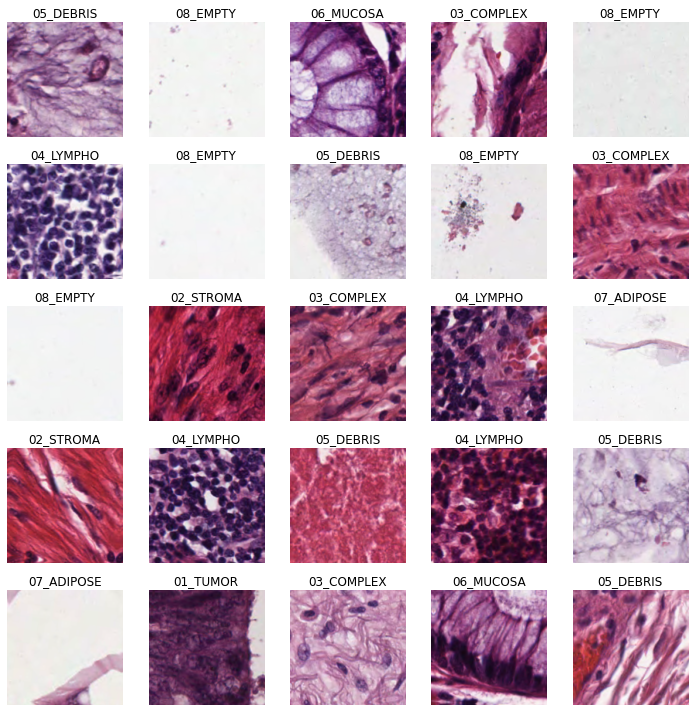

In [ ]:
data.show_batch(row=1, figsize=(10,10))

In [ ]:
# Hasil pengerjaan point 1.4

# 2. Modelling (35 + 10 point)
Task yang perlu dikerjakan:
- 1. Membuat 2 Model Tranfer Learning menggunakan minimal 2 kombinasi pretrained architecture (20 point)
- 2. Melakukan training pembobotan pada layer eksperiment kemudian simpan model dengan hasil akurasi validasi paling tinggi (15 point)
- 3. Anda dapat menggunakan improvisasi pada modul sebelumnya dengan menggunakan dropout, regulizer, early stopping, callback training, grid search, dsb. (tambahan 10 point jika bisa menunjukkan peningkatan akurasi dari improvisasi model)

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import concatenate
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input


In [13]:
input = Input(shape = (224,224,3), name='net_1_input')
inceptionv3 = InceptionV3(input_tensor=input, include_top=False, weights='imagenet')(input_1)
resnet = ResNet50(input_tensor=input, include_top=False, weights='imagenet')(input_1)

net_1 = concatenate([inceptionv3, resnet])
net_1 = GlobalAveragePooling2D(name='global_a_p2d')(net_1)
net_1 = Dropout(.2)(net_1)
net_1 = Dense(units=2048, activation='relu', name='net_1_d')(net_1)
net_1 = Dense(units=8, activation='softmax', name='net_1_s')(net_1)
model_1 = Model(inputs = input_1, outputs=net_1, name='net_1_m')
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['categorical_accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


NameError: ignored

In [14]:
# Hasil pengerjaan point 2.1 (model 1)
input = Input(shape=(224,224,3))

inceptionv3 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input
    )

resnet50 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input
    )

x = concatenate([inceptionv3, resnet50])
x = GlobalAveragePooling2D(x)
x = Dropout(.2)(x)
x = Dense(units=2048, activation='relu')(x) 
x = Dense(units=8, activation='softmax')(x)
model_1 = Model(inputs=input, outputs=x, name = 'model_1')
model_1.compile(optimizer='rsprop', loss='mse', metrics=['categorical_accuracy'])

TypeError: ignored

In [ ]:
# Hasil pengerjaan point 2.1 (model 2)
input = (224,224,3)

inceptionv3 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input
    )

densenet121 = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input
    )

x = concatenate([inceptionv3, DenseNet121], axis=1)

x = GlobalAveragePooling2D(x)

x = Dropout(.2)(x)

x = Dense(units=2048, activation='relu')(x) 

x = Dense(units=8, activation='softmax')(x)

model_1 = Model(inputs=input, outputs=x, name = 'model_1')

model_1.compile(optimizer='rsprop', loss='mse', metrics=['categorical_accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
resnet101 (Model)               (None, 5, 5, 2048)   42658176    input_1[0][0]                    
__________________________________________________________________________________________________
xception (Model)                (None, 5, 5, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_concat_2 (TensorFlo [(None, 5, 5, 4096)] 0           resnet101[1][0]                  
                                                                 xception[1][0]             

In [ ]:
# Hasil pengerjaan point 2.2 (model 1)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 12.7478 - accuracy: 0.6812
Epoch 00001: val_accuracy improved from -inf to 0.82700, saving model to model1.h5
32/32 [==============================] - 24s 763ms/step - loss: 12.7478 - accuracy: 0.6812 - val_loss: 3.9163 - val_accuracy: 0.8270
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 2.5147 - accuracy: 0.8547
Epoch 00002: val_accuracy improved from 0.82700 to 0.84400, saving model to model1.h5
32/32 [==============================] - 17s 541ms/step - loss: 2.5147 - accuracy: 0.8547 - val_loss: 1.6065 - val_accuracy: 0.8440
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 1.3099 - accuracy: 0.8500
Epoch 00003: val_accuracy improved from 0.84400 to 0.85800, saving model to model1.h5
32/32 [==============================] - 17s 526ms/step - loss: 1.3099 - accuracy: 0.8500 - val_loss: 1.0658 - val_accuracy: 0.8580
Epoch 4/10
32/32 [==============================] - ETA: 0s - los

In [ ]:
# Hasil pengerjaan point 2.2 (model 2)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.3624 - accuracy: 0.6077
Epoch 00001: val_accuracy improved from -inf to 0.78400, saving model to model2.h5
32/32 [==============================] - 25s 795ms/step - loss: 1.3624 - accuracy: 0.6077 - val_loss: 0.8408 - val_accuracy: 0.7840
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.8125
Epoch 00002: val_accuracy improved from 0.78400 to 0.83100, saving model to model2.h5
32/32 [==============================] - 22s 690ms/step - loss: 0.7564 - accuracy: 0.8125 - val_loss: 0.6701 - val_accuracy: 0.8310
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.8480
Epoch 00003: val_accuracy improved from 0.83100 to 0.85300, saving model to model2.h5
32/32 [==============================] - 22s 684ms/step - loss: 0.6436 - accuracy: 0.8480 - val_loss: 0.6144 - val_accuracy: 0.8530
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss:

# 3. Report & Deploy (25 + 5 point):
Task yang perlu dikerjakan:
- 1. Load hasil penyimpanan model terbaik dari callback (5 point)
- 2. Membuat klasifikasi report dari 2 hasil model penyimpanan tersebut (10 point)
- 3. Uji coba pada 10 gambar untuk mendapatkan hasil label klafikasi gambar dari hasil model yang disimpan (10 point)
- 4. Menunjukkan history training kedua model melalui tensorboard (tambahan 5 point)

In [ ]:
# Hasil pengerjaan point 3.1 (model 1)

In [ ]:
# Hasil pengerjaan point 3.2

model 1
              precision    recall  f1-score   support

       tumor       0.75      0.96      0.84       112
      stroma       0.75      0.91      0.83       127
     complex       0.74      0.66      0.69       137
      lympho       0.94      0.83      0.88       126
      debris       0.97      0.67      0.79       126
      mucosa       0.92      0.93      0.93       128
     adipose       0.98      0.97      0.98       118
       empty       0.93      1.00      0.96       126

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.86      1000
weighted avg       0.87      0.86      0.86      1000

model 2
              precision    recall  f1-score   support

       tumor       0.84      0.88      0.86       112
      stroma       0.89      0.80      0.84       127
     complex       0.76      0.75      0.76       137
      lympho       0.90      0.90      0.90       126
      debris       0.81      0.87      0.84       126
      mu

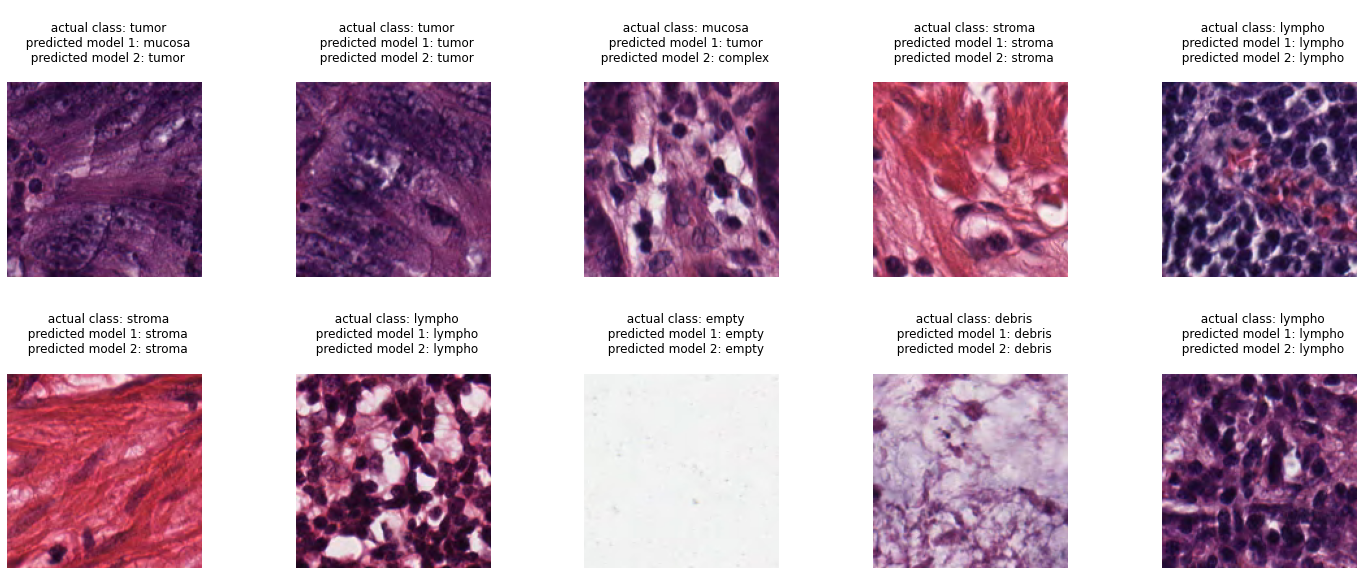

In [ ]:
# Hasil pengerjaan point 3.3